
**Universidad de los Andes**<br>
Facultad de Ingeniería<br>
__Maestría en Inteligencia Artificial__

# Detección de muestrarios de color a partir de obras de arte

Autores: __Andrés Vega__ y __David Méndez Acuña__

### Introducción

En este notebook, presentamos nuestra solución al primer micro-proyecto del curso de machine learning no supervisado. El objetivo es generar automáticamente muestrarios de colores a partir de obras de arte usando algoritmos de agrupación que permitan identificar colores predominantes en la imagen. A grandes rasgos, nuestra propuesta se basa en cuatro etapas organizadas en el pipeline de ejecución presentado en la Figura 1. 

<br>
<center>
    <img src="https://raw.githubusercontent.com/damenac/maia-uml/main/micro-proyectos/1_color_clustering/pipeline.png" width="600">
</center>
<center>
Figura 1. Pipeline de ejecución para resolver el problema de generación automática de muestrarios de colores a partir de obras de arte.
</center>
<br>

A continuación, se describen brevemente cada uno de los pasos del pipeline. Los detalles de implementación y las decisiones técnicas que se tomaron en cada paso se describirán y justificarán a lo largo de este documento. 

- **Cargar imágenes.** En este primer paso del pipeline se cargan las imágenes a partir de los archivos que las contienen. En este punto, tenemos la imagen original con sus dimensiones iniciales y sin ningún tipo de procesamiento previo. En en caso de este proyecto, se trata de imagenes de resolución relativamente alta.

- **Preparar imágenes.** En este segundo paso se preparan las imánenes para el algoritmo. Concretamente, se reduce la complejidad de la imagen para incrementar el desempeño del algoritmo de agrupación y reducir el tiempo de ejecución. Con este fin, se reduce la resolución de las imágenes y se hace uso del método de análisis de componentes principales (PCA) para reducir la dimensionalidad de la matriz correspondiente a la imagen. También se hace uso del algoritmo de t-SNE que permitirá visualizar las imágenes en una representación de dos dimesiones. Finalmente, se aplican los conceptos de aplanamiento y normalización para facilitar la manipulación numérica del algoritmo.

- **Ejecutar algoritmo.** En el tercer paso, se ejecuta el algoritmo de K-Means, dando como parámetro del modelo los 6 grupos que son requeridos por el ejercicio, se hizo la agrupación y posterior graficación de los resultados. Para validar la cantida de grupos, usamos los métodos del codo y la silueta.

- **Visualizar resultados.** En este último paso, se despliegan en pantalla los resultados de los pasos anteriores.

**Nota:** A lo largo de todo el notebook, se constryen progresivamente ciertas clases que implementan los pasos de un pipeline que se ejecutará al final consolidando así la ejecución en un único punto de entrada.

## Librerías requeridas

In [1]:
import pandas as pd
from datetime import datetime
import os
import cv2
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
from sklearn_extra.cluster  import KMedoids
from sklearn.preprocessing import RobustScaler

## Definición del contexto

Cada uno de los pasos del pipeline va a producir información importante que se quiere almacenar para desplegar los resultados al final en un paso dedicado a ello. Para poder propagar esa información a lo largo del pipeline, se usa un objeto de contexto que será enriquecido progresivamente durante la ejecución. 

In [2]:
class Context:
    '''
    Clase que permite almacenar el contexto de ejecución de los pasos 
    del pipeline. Esta clase será particularmente útil en el último 
    paso del pipeline donde necesitaremoslos datos generados por todos 
    los pasos del pipeline para imprimir el detalle de los resultados.
    '''
    def __init__(self, model) -> None:
        self.model = model

    def log(message=None):
        '''
        Imprime el mensaje que entra por parámetro acompañado de la hora 
        actual. Este método será util para la trazabilidad de la ejecución
        del pipeline.  
        '''
        now = datetime.now()
        print(f'[INFO] {now.strftime("%H:%M:%S")} — {message}')

## Recopilación de un conjunto diverso de imágenes

El conjunto diverso de imágenes que usaremos a lo largo de este proyecto se presenta en la Figura 2. Para seleccionar dichas imágenes tuvimos en cuenta varios aspectos. Por un lado, queremos evaluar el algoritmo en imágenes con **diferente nivel de detalle**. Es por esto que seleccionamos por lo menos una obra de arte del realismo y una del pop art. Por otro lado, queremos ver el comportamiento del algoritmo tanto en imágenes en blanco y negro como en imágenes con una gran **cantidad de colores**. Finalmente, queremos validar que los muestrarios de colores son realmente independientes por lo que incluimos dos **imágenes que no comparten colores**. En este caso, esperamos dos muestrarios completamente distintos. 

<br>
<center>
    <img src="https://raw.githubusercontent.com/damenac/maia-uml/main/micro-proyectos/1_color_clustering/imagenes-entrenamiento.png?token=GHSAT0AAAAAACN5BJIDOHHCCSIMC27L4KQAZO5FZRQ" width="600">
</center>
<br>

Dichas imágenes se encuentran en el directorio `images`. Se define entonces el directorio raíz `root_path` y la lista de imágenes `img_files`:

In [3]:
root_path = 'images'
img_files = [
    '1_aki-kuroda_untitled-1995.jpg',
    '2_aleksey-savrasov_little-house-in-the-province-spring-1878.jpg',
    '3_aaron-siskind_acolman-1-1955.jpg',
    '4_hans-hofmann_untitled-1942.jpg',
    '5_aki-kuroda_cosmogarden-2011.jpg',
    '6_alfred-stevens_portrait-of-mrs-howe-1900.jpg'
]
img_files

['1_aki-kuroda_untitled-1995.jpg',
 '2_aleksey-savrasov_little-house-in-the-province-spring-1878.jpg',
 '3_aaron-siskind_acolman-1-1955.jpg',
 '4_hans-hofmann_untitled-1942.jpg',
 '5_aki-kuroda_cosmogarden-2011.jpg',
 '6_alfred-stevens_portrait-of-mrs-howe-1900.jpg']

## Cargar imágenes

Se define una clase ImageLoader para la carga de las imágenes. Esta clase asume que se tiene un archivo con la imagen, y utiliza funciones como imread() y cvtColor() para cargarla:

In [4]:
class ImageLoader(BaseEstimator, TransformerMixin) :
    '''
    Este paso del pipeline se encarga de cargar la imagen a partir de un 
    archivo. En este paso se recibe un archivo y se retorna una matriz 
    de pixeles en formato RGB. 
    '''
    def __init__(self, context) -> None:
        self.context = context

    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        '''
        Recibe un archivo en el parámetro X y retorna una matriz de 
        pixeles en formato RGB como resultado de la transformación. 
        '''
        Context.log(message='PASO 1: Cargar la imagen | Inicio de la ejecución')
        img = cv2.imread(os.path.join(root_path, X))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        self.context.original_image = img
        Context.log(message='PASO 1: Cargar la imagen | Fin de la ejecución')
        return img

## Preparación de los datos

Ya que tenemos las imágenes originales, procedemos a prepararlas para la ejecución del algoritmo. A continuación se describen cada una de las operaciones que se aplican en este proceso.

- **Reducción de la resolución.** Las imágenes que tenemos que tratar son relativamente grandes con resoluciones de 1400x1400 en promedio. Esto es un problema porque el algoritmo de t-SNE toman mucho tiempo en este tipo de imágenes (incluso luego de haber aplicado PCA). Debemos entonces reducir la resolución de las imágenes para mejorar los tiempos de respuesta de t-SNE. En este caso, proponemos una reducción a una resolución de 200x200. Para llegar a este número, hicimos varios intentos y conservamos el valor máximo que permite una ejecución de t-SNE en un máximo de dos minutos cuando se ejecuta en un computador personal de capacidad estándar.

- **Reducción de la dimensionalidad.** Se aplica el método de análisis de componentes principales para reducir la dimensionalidad. A partir de una validación visual, pudimos determinar que el número de componentes no puede ser mejor a cuatro. Se observó, por ejemplo que con tres componentes, se pierde el rojo y el verde en la primera obra de Aki Kuroda. Es interesante ver que, incluso si se usan ocho grupos, esos dos colores predominantes en la imagen no aparecen. Al usar PCA con 4 componentes, los resultados son mucho mejores manteniendo tiempos de ejecución razonables. A partir de cuatro componentes, no se notaron mejoras importantes en la calidad el muestrario. Es por ello que decidimos fijar el valor por defecto de los componentes de PCA en cuatro. 

<br>
<center>
    <img src="https://raw.githubusercontent.com/damenac/maia-uml/main/micro-proyectos/1_color_clustering/aki-kuroda-pca-3.png" width="600">
</center>
<center>
Figura 3. Resultados sobre la obra de Aki Kuroda usando PCA con 3 componentes principales. Note que los colores rojo y verde (que parecen importantes en la imagen) desaparecen del muestrario.
</center>
<br>

- **Representación en dos dimensiones.** Con el fin de entender los resultados, se usa t-SNE para obtener una representación en dos dimensiones. Este algoritmo se aplica sobre la imagen con dimensionalidad reducida gracias al PCA. Note que este es el paso del procesamiento que toma mas tiempo. Como se mencionó anteriormente, pare reducir los tiempos de ejecución se redujo la resolución de la imagen y se aplica t-SNE luego de haber aplicado PCA. 

- **Normalización de la imagen.** Finalmente, se normalizan los valores de la imagen para que estén en el rango [0, 1]. Este será el conjunto de datos que se utilizará para la ejecución del algoritmo.

In [5]:
class ImageProcessor(BaseEstimator, TransformerMixin) :
    '''
    Este paso del pipeline se encarga de hacer el pre-procesamiento 
    necesario para el entrenamiento del modelo. Concretamente, 
    en este paso se recibe una imagen como una matriz de pixeles 
    en RGB se retorna un arreglo de números. El arreglo esta normalizado. 
    Además, se reduce la dimensionalidad de la imagen usando PCA. 
    '''
    def __init__(self, context, num_components=4) -> None:
        self.context = context
        self.num_components = num_components

    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        '''
        Recibe una matriz de pixeles RGB en el parámetro X y retorna un 
        arreglo de tres dimensiones normalizado al rango [0, 1]. 
        '''
        Context.log(message='PASO 2: Preparación de la imagen | Inicio de la ejecución')

        # Reducción de la resolución de la imagen a 200x200
        resized_img = self.format_image(X, flatten=False, normalize=False, resize=True)

        # Applicando reducción de la dimensionalidad.
        reduced_img = self.apply_pca(resized_img)

        # Transformando la imagen en un arreglo de N*3 para facilitar el procesamiento.
        flattened_img = self.format_image(reduced_img, flatten=True, normalize=False, resize=False)

        # Aplicando t-SNE sobre la imagen reducida
        tsne = self.apply_tsne(flattened_img)

        # Normalizando el arreglo 
        normalized_image = flattened_img / 255.0

        # Transformando la imagen en un data frame necesario para los métodos de la silueta
        # y del codo para determinar la cantidad de grupos que se quieren identificar.
        formatted_image = self.format_image(X, flatten=True, normalize=True, resize=True)
        formatted_image_df = pd.DataFrame(data = formatted_image, columns=["Red", "Green", "Blue"])

        robust_scaler = RobustScaler()
        scaled_data = robust_scaler.fit_transform(formatted_image_df)
        scaled_df = pd.DataFrame(scaled_data, columns=formatted_image_df.columns)

        self.context.resized_img = resized_img
        self.context.normalized_image = self.force_max(abs(normalized_image))
        self.context.tsne = tsne
        self.context.reduced_image = reduced_img
        self.context.formatted_image_df = formatted_image_df
        self.context.scaled_df = scaled_df

        Context.log(message='PASO 2: Preparación de la imagen | Valores nulos: {nulos}'.format(nulos=formatted_image_df.isna().sum()))
        Context.log(message='PASO 2: Preparación de la imagen | Fin de la ejecución')
        Context.log(message='PASO 3: Ejecución del algoritmo | Inicio de la ejecución')
        return normalized_image
    

    def format_image(self, img, flatten=True, normalize=True, resize=False):
        '''
        Retorna una lista con arreglos de números. Cada arreglo representa una imagen RGB.
        
        Parametros:
        img : numpy.array
            Matriz que contiene la imagen original.
        flatten : bool, opcional
            Si es True, aplana las imágenes a una lista de píxeles de tres dimensiones.
        normalize : bool, opcional
            Si es True, normaliza los valores de píxeles al rango [0, 1].
        resize : bool, opcional
            Si es True, reduce la resolución de la imagen a 200x200.
        '''

        if resize:
            img = cv2.resize(img, (200, 200))
        if flatten:
            img = img.reshape((-1, 3))
        if normalize:
            img = img / 255.0

        return img
    
    
    def apply_pca(self, img) :
        '''
        Recibe una imagen como una matriz de pixeles en RGB y retorna
        el resultado de apilcar PCA sobre dicha matriz. 
        '''
        Context.log(message='   PCA | Inicio de la ejecución')
        
        x = len(img)    
        y = len(img[0])
        z = len(img[0][0])

        reduced_img = img.reshape((x, y*z))
        pca = PCA(n_components = self.num_components)
        reduced_img = pca.fit_transform(reduced_img)
        reduced_img = pca.inverse_transform(reduced_img)
        reduced_img = reduced_img.reshape((x, y, z))
        Context.log(message='   PCA | Fin de la ejecución')

        return reduced_img
    

    def apply_tsne(self, img) :
        '''
        Recibe una imagen en la cual se ha aplicado previamente PCA, y retorna
        una representación en dos dimensiones obtanida a partir del algoritmo de t-SNE. 
        '''
        Context.log(message='   t-SNE | Inicio de la ejecución')
        tsne = TSNE(random_state=0, verbose=0, n_jobs=-1)
        response = pd.DataFrame(tsne.fit_transform(img))
        Context.log(message='   t-SNE | Fin de la ejecución de t-SNE')
        return response
    

    def force_max(self, img):
        '''
        Este método aplica una función techo a los valores de la imagen que entra por
        parámetro. Se observa que, incluso luego de normalizada, hay algunos valores que
        exceden 1. Para corregir estas anomalías, aplicamos este método sobre la imagen
        de manera preventiva. 
        '''
        result = []
        for i in range(len(img)):
            result.append([])
            for j in range(len(img[i])):
                value = img[i][j]
                if value > 1:
                    value = 1
                result[i].append(value)
        return result

## Construcción del modelo de agrupación - KMeans

En este paso se ejecuta el algoritmo de agrupación. Luego de haber experimentado con varios modelos, nuestra conclusión es que k-means es el algoritmo más apropiado porque ofrece resultados adecuados en tiempos de ejecución aceptables, y en todo caso menores a otros algotimos.

Para decidir sobre la cantidad de grupos, ejecutamos los métodos del codo y la silueta para cada imagen. Los resultados sugieren que seis grupos (seis colores) son una solución apropiada. Las gráficas correspondientes al análisis del codo y la silueta se imprimen como parte de la etapa de ejecución del algoritmo. Note que los resultados del análisis del codo y de la silueta no son iguales en todas las imágenes y eso es interesante. ¿Cómo elegir una imagen representativa que nos ayude a seleccionar la cantidad de grupos que se adapte a todas? La pregunta queda abierta y nuestra propuesta es usar seis dado que parece promediar los resultados de todas las imágenes. 

In [6]:
class Algorithm(BaseEstimator, TransformerMixin) :

    def __init__(self, context) -> None:
        self.context = context

    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        k_min = 4
        k_max = 8

        inertias = self.elbow_plot(self.context.scaled_df, k_min, k_max)
        scores = self.silhouette_plot(self.context.scaled_df, k_min, k_max)
        self.print_analysis(k_min, k_max, inertias, scores)

        return X

    def elbow_plot(self, X, k_min=2, k_max=10):
        """
        Genera la gráfica para el método del codo usando KMeans
        
        Parametros:
        X : np.array
            El arreglo con los datos
        model : str
            "kmeans" o "kmedoids", especifica el modelo a entrenar.
        k_min : int
            Valor mínimo para k
        k_max : int
            Valor máximo para k
        """
        inertias = []
        for i in range(k_min, k_max+1):
            model_k = KMeans(n_clusters=i, max_iter=300, n_init=10, random_state=0)
            model_k.fit(X)
            inertias.append(model_k.inertia_)

        return inertias


    def silhouette_plot(self, X, k_min=2, k_max=5):
        """
        Genera la gráfica con el coeficiente de la silueta
        
        Parametros:
        X : np.array
            El arreglo con los datos
        model : str
            "kmeans" o "kmedoids", especifica el modelo a entrenar.
        k_min : int
            Valor mínimo para k
        k_max : int
            Valor máximo para k
        """
        scores = []
        for i in range(k_min, k_max+1):
            model_k = KMeans(n_clusters=i, max_iter=300, n_init=10, random_state=0)
            model_k.fit(X)
            score = silhouette_score(X, model_k.labels_)
            scores.append(score)

        return scores
        

    def print_analysis(self, k_min, k_max, inertias, scores):
        plt.figure(figsize=(15, 3))

        # Graficamos los valores de inercia
        plt.subplot(1, 2, 1)
        plt.plot(range(k_min,k_max+1), inertias, marker='o')
        plt.xlabel('Número de clústeres')
        plt.ylabel('Inercia')
        plt.grid()
        #plt.show()
        
        # Graficamos los valores del coeficiente de la silueta
        plt.subplot(1, 2, 2)
        plt.plot(range(k_min,k_max+1), scores, marker='o')
        plt.xlabel('Número de clústeres')
        plt.ylabel('Silhouette Score')
        plt.grid()
        plt.show()

num_clusters = 6
kmeans = KMeans(max_iter=300, n_init=10, n_clusters=num_clusters)

### Visualización de resultados.
En el siguiente paso del pipeline, se imprimen las imágenes generadas durante la ejecución del pipeline. Concretemente, se presentan cuatro figuras distintas para cada imagen:

- Imagen original sin ninguna manipulación.
- Representación en dos dimensiones de la imagen obtenida a partir del algoritmo de t-SNE. En este caso, los puntos conservan los colores originales. Entonces, se trata de una vista en el plano cartesiano de la imagen original. 
- Muestrario de colores obtenido a partir del resultado del algoritmo de agrupación. Cada uno de los colores en el muestrario corresponde a un centroide. 
- Representación en dos dimensiones de la imagen segmentada usando los centroides. Esta vista es interesante porque permite visualizar los grupos identificados por el algoritmo.

In [7]:
class PrettyPrinter(BaseEstimator, TransformerMixin) :
    '''
    Finalmente, queremos imprimir las imagenes original y 
    segmentada así como la paleta de colores formada por los 
    centroides encontrados por k-means. 
    '''
    def __init__(self, context) -> None:
        self.context = context

    def fit(self, X, y=None):
        Context.log(message='PASO 3: Ejecución del algoritmo | Fin de la ejecución')
        Context.log(message='PASO 4: Visualización de resultados | Inicio de la ejecución')

        # Imprimiendo la imagen original
        figsize = len(self.context.original_image) * 0.0021
        colors = self.context.model.cluster_centers_
        plt.figure(figsize=(15, figsize))

        plt.subplot(1, 4, 1)
        plt.title('Imagen original')
        plt.imshow(self.context.original_image)
        plt.axis('off')

        # Imprimiendo la representación en 2D como resultado de aplicar T-SNE
        plt.subplot(1, 4, 2)
        plt.title('Representación original en 2D')
        labels = self.context.model.labels_
        segmented_img = colors[labels]
        segmented_img = segmented_img.reshape(segmented_img.shape)
        segmented_img = pd.DataFrame(data=segmented_img)
        normalized_img = pd.DataFrame(data=self.context.normalized_image)

        MARKER = ['o', 'v', '1', 'p' ,'*', '+', 'x', 'd', '4', '.']
        for i in range(len(colors)):
            color=[colors[i][0], colors[i][1], colors[i][2]]
            selections = self.context.tsne.iloc[segmented_img[segmented_img==color].index]
            plt.scatter(selections[0], selections[1],  marker=MARKER[i], c=normalized_img)

        # Imprimiendo el muestrario de colores
        ax = plt.subplot(1, 4, 3)
        plt.title('Muestrario de colores')

        ax.plot([0, 0],[0, 0])
        lenght = 1
        initial_position = 0
        for i in range(len(colors)):
            color=[colors[i][0], colors[i][1], colors[i][2]]
            ax.add_patch(Rectangle((initial_position, 0), lenght, 6, color=color))
            initial_position += lenght
        
        plt.axis('off')
        
        # Imprimiendo la representación en 2D como resultado de aplicar T-SNE

        plt.subplot(1, 4, 4)
        plt.title('Representación segmentada en 2D')
        labels = self.context.model.labels_
        segmented_img = colors[labels]
        segmented_img = segmented_img.reshape(segmented_img.shape)
        segmented_img = pd.DataFrame(data=segmented_img)
        normalized_img = pd.DataFrame(data=self.context.normalized_image)

        for i in range(len(colors)):
            color=[colors[i][0], colors[i][1], colors[i][2]]
            selections = self.context.tsne.iloc[segmented_img[segmented_img==color].index]
            plt.scatter(selections[0], selections[1],  marker=MARKER[i], c=segmented_img)
        
        plt.show()

        Context.log(message='PASO 4: Visualización de resultados | Fin de la ejecución')
        print('----')
        print('')
        
        return self
    
    def transform(self, X, y=None):
        return X

## Ejecución del pipeline

Finalmente, podemos definir y ejecutar el pipeline a partir de los pasos construidos anteriormente. 
Especifico un máximo de iteraciones con el parámetro `max_iter`, defino `n_init=10` el cual es el valor por defecto para el número de veces en que el algoritmo K-Means se ejecuta con diferentes semillas de centroides

[INFO] 15:54:25 — PASO 1: Cargar la imagen | Inicio de la ejecución
[INFO] 15:54:25 — PASO 1: Cargar la imagen | Fin de la ejecución
[INFO] 15:54:25 — PASO 2: Preparación de la imagen | Inicio de la ejecución
[INFO] 15:54:25 —    PCA | Inicio de la ejecución


[INFO] 15:54:28 —    PCA | Fin de la ejecución
[INFO] 15:54:28 —    t-SNE | Inicio de la ejecución
[INFO] 15:55:51 —    t-SNE | Fin de la ejecución de t-SNE
[INFO] 15:55:51 — PASO 2: Preparación de la imagen | Valores nulos: Red      0
Green    0
Blue     0
dtype: int64
[INFO] 15:55:51 — PASO 2: Preparación de la imagen | Fin de la ejecución
[INFO] 15:55:51 — PASO 3: Ejecución del algoritmo | Inicio de la ejecución


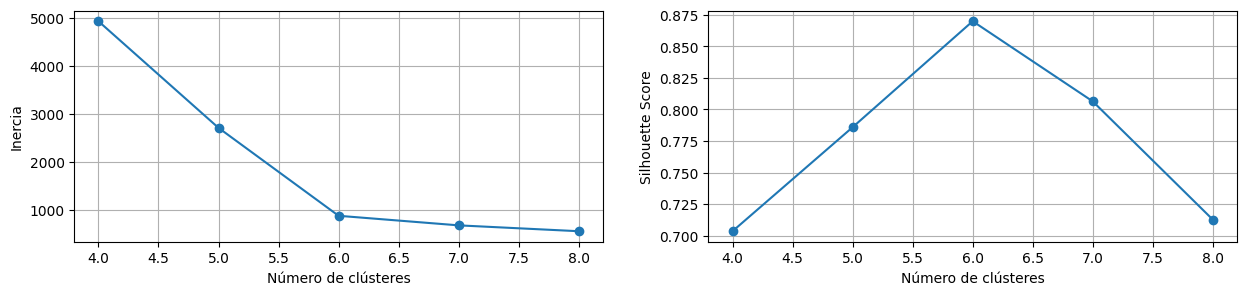

[INFO] 15:57:09 — PASO 3: Ejecución del algoritmo | Fin de la ejecución
[INFO] 15:57:09 — PASO 4: Visualización de resultados | Inicio de la ejecución


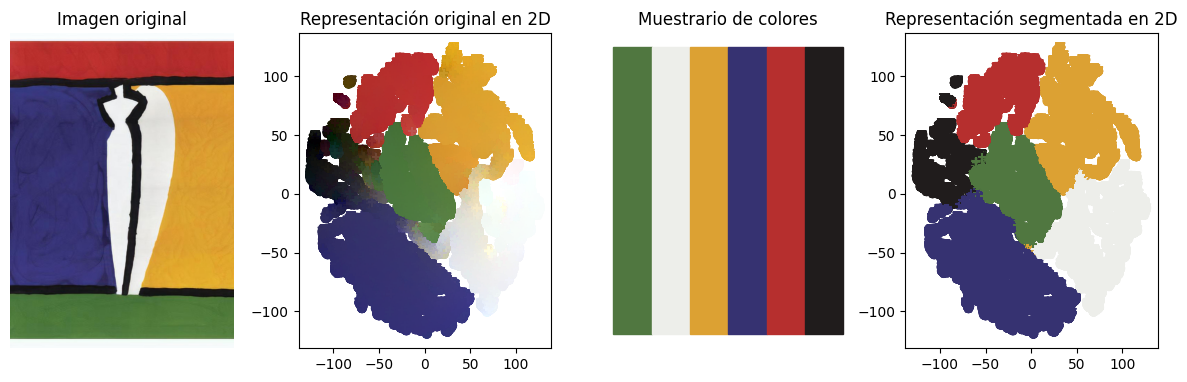

[INFO] 15:57:11 — PASO 4: Visualización de resultados | Fin de la ejecución
----

[INFO] 15:57:11 — PASO 1: Cargar la imagen | Inicio de la ejecución
[INFO] 15:57:11 — PASO 1: Cargar la imagen | Fin de la ejecución
[INFO] 15:57:11 — PASO 2: Preparación de la imagen | Inicio de la ejecución
[INFO] 15:57:11 —    PCA | Inicio de la ejecución
[INFO] 15:57:13 —    PCA | Fin de la ejecución
[INFO] 15:57:13 —    t-SNE | Inicio de la ejecución
[INFO] 15:58:41 —    t-SNE | Fin de la ejecución de t-SNE
[INFO] 15:58:41 — PASO 2: Preparación de la imagen | Valores nulos: Red      0
Green    0
Blue     0
dtype: int64
[INFO] 15:58:41 — PASO 2: Preparación de la imagen | Fin de la ejecución
[INFO] 15:58:41 — PASO 3: Ejecución del algoritmo | Inicio de la ejecución


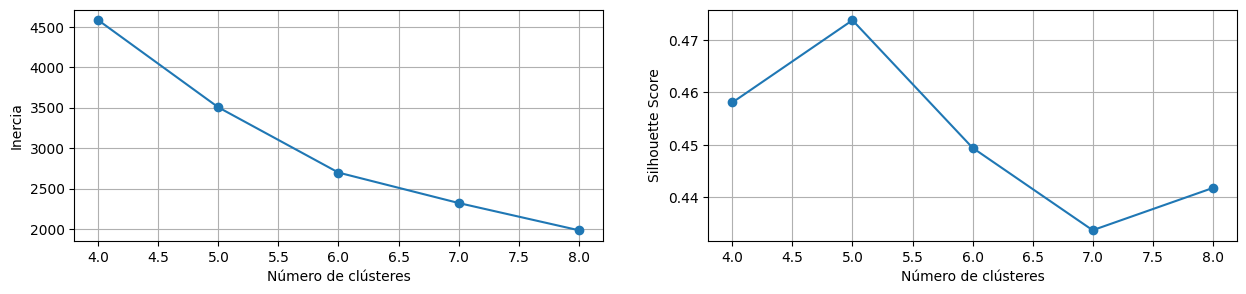

[INFO] 15:59:54 — PASO 3: Ejecución del algoritmo | Fin de la ejecución
[INFO] 15:59:54 — PASO 4: Visualización de resultados | Inicio de la ejecución


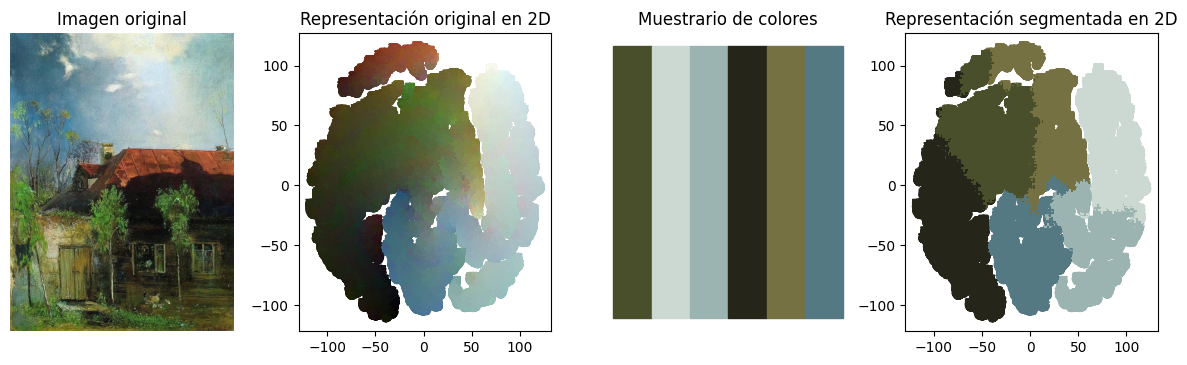

[INFO] 15:59:56 — PASO 4: Visualización de resultados | Fin de la ejecución
----

[INFO] 15:59:56 — PASO 1: Cargar la imagen | Inicio de la ejecución
[INFO] 15:59:56 — PASO 1: Cargar la imagen | Fin de la ejecución
[INFO] 15:59:56 — PASO 2: Preparación de la imagen | Inicio de la ejecución
[INFO] 15:59:56 —    PCA | Inicio de la ejecución
[INFO] 15:59:59 —    PCA | Fin de la ejecución
[INFO] 15:59:59 —    t-SNE | Inicio de la ejecución
[INFO] 16:01:41 —    t-SNE | Fin de la ejecución de t-SNE
[INFO] 16:01:41 — PASO 2: Preparación de la imagen | Valores nulos: Red      0
Green    0
Blue     0
dtype: int64
[INFO] 16:01:41 — PASO 2: Preparación de la imagen | Fin de la ejecución
[INFO] 16:01:41 — PASO 3: Ejecución del algoritmo | Inicio de la ejecución


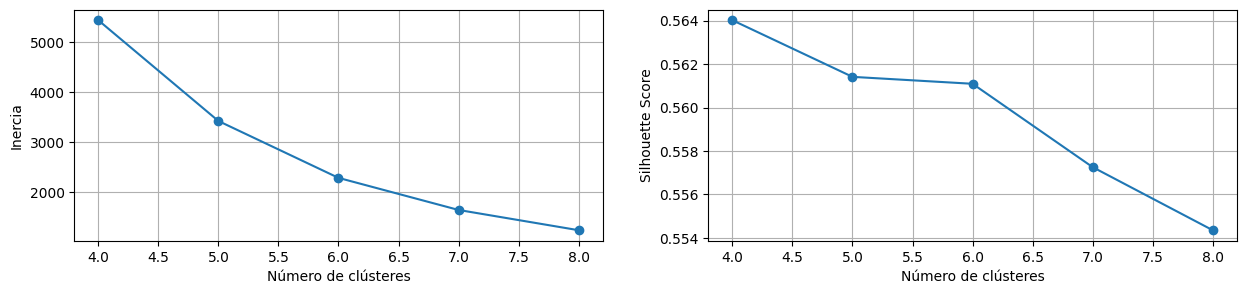

[INFO] 16:02:48 — PASO 3: Ejecución del algoritmo | Fin de la ejecución
[INFO] 16:02:48 — PASO 4: Visualización de resultados | Inicio de la ejecución


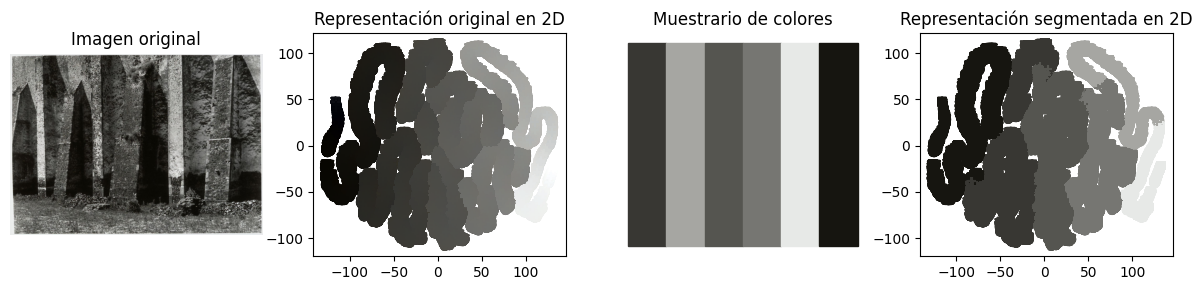

[INFO] 16:02:50 — PASO 4: Visualización de resultados | Fin de la ejecución
----

[INFO] 16:02:50 — PASO 1: Cargar la imagen | Inicio de la ejecución
[INFO] 16:02:50 — PASO 1: Cargar la imagen | Fin de la ejecución
[INFO] 16:02:50 — PASO 2: Preparación de la imagen | Inicio de la ejecución
[INFO] 16:02:50 —    PCA | Inicio de la ejecución
[INFO] 16:02:53 —    PCA | Fin de la ejecución
[INFO] 16:02:53 —    t-SNE | Inicio de la ejecución
[INFO] 16:04:24 —    t-SNE | Fin de la ejecución de t-SNE
[INFO] 16:04:24 — PASO 2: Preparación de la imagen | Valores nulos: Red      0
Green    0
Blue     0
dtype: int64
[INFO] 16:04:24 — PASO 2: Preparación de la imagen | Fin de la ejecución
[INFO] 16:04:24 — PASO 3: Ejecución del algoritmo | Inicio de la ejecución


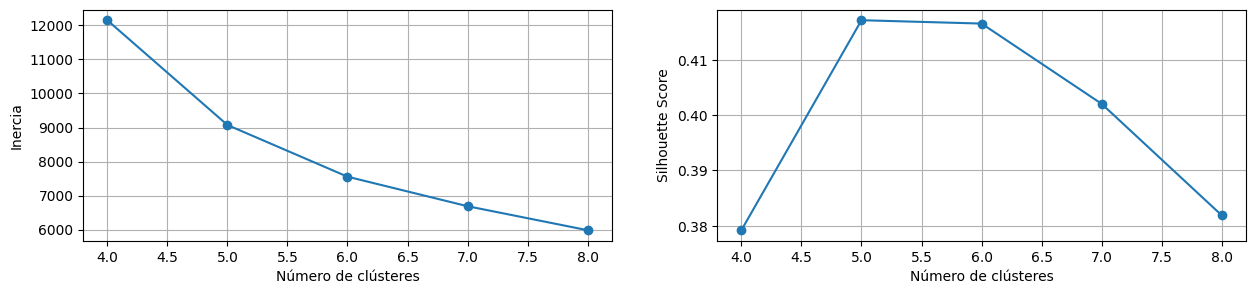

[INFO] 16:05:42 — PASO 3: Ejecución del algoritmo | Fin de la ejecución
[INFO] 16:05:42 — PASO 4: Visualización de resultados | Inicio de la ejecución


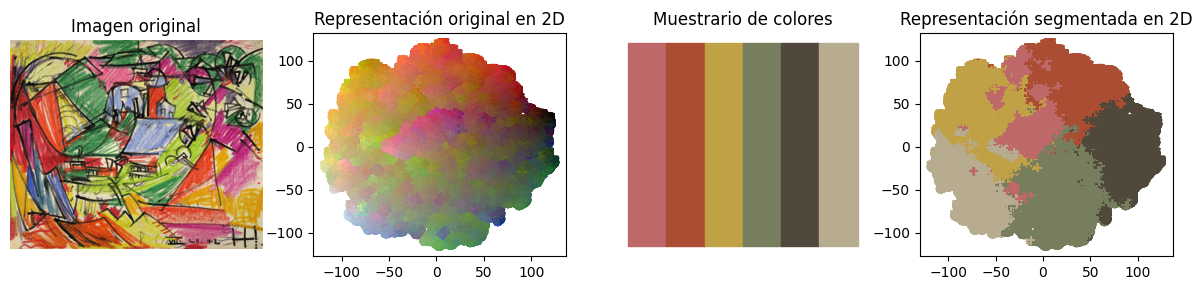

[INFO] 16:05:44 — PASO 4: Visualización de resultados | Fin de la ejecución
----

[INFO] 16:05:44 — PASO 1: Cargar la imagen | Inicio de la ejecución
[INFO] 16:05:44 — PASO 1: Cargar la imagen | Fin de la ejecución
[INFO] 16:05:44 — PASO 2: Preparación de la imagen | Inicio de la ejecución
[INFO] 16:05:44 —    PCA | Inicio de la ejecución
[INFO] 16:05:46 —    PCA | Fin de la ejecución
[INFO] 16:05:46 —    t-SNE | Inicio de la ejecución
[INFO] 16:07:16 —    t-SNE | Fin de la ejecución de t-SNE
[INFO] 16:07:16 — PASO 2: Preparación de la imagen | Valores nulos: Red      0
Green    0
Blue     0
dtype: int64
[INFO] 16:07:16 — PASO 2: Preparación de la imagen | Fin de la ejecución
[INFO] 16:07:16 — PASO 3: Ejecución del algoritmo | Inicio de la ejecución


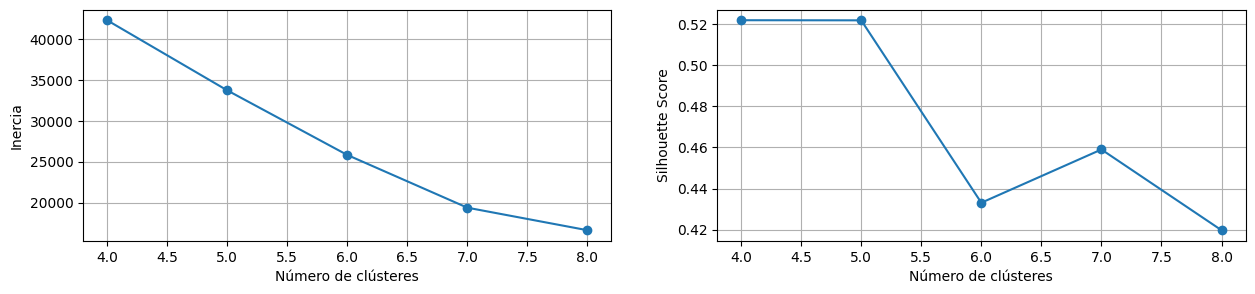

[INFO] 16:08:34 — PASO 3: Ejecución del algoritmo | Fin de la ejecución
[INFO] 16:08:34 — PASO 4: Visualización de resultados | Inicio de la ejecución


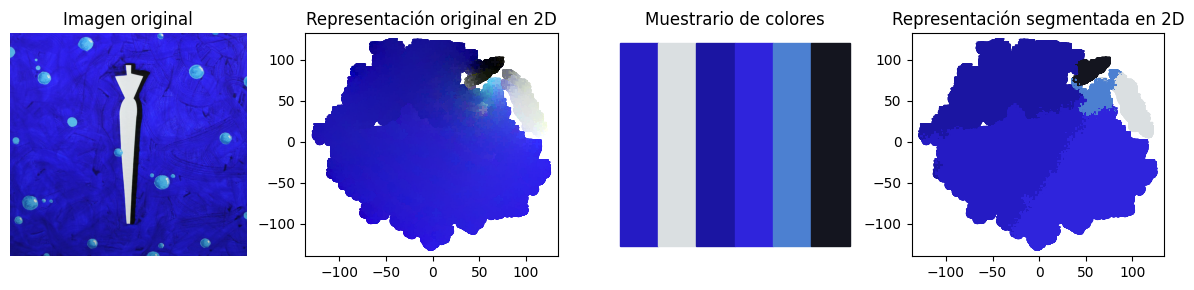

[INFO] 16:08:36 — PASO 4: Visualización de resultados | Fin de la ejecución
----

[INFO] 16:08:36 — PASO 1: Cargar la imagen | Inicio de la ejecución
[INFO] 16:08:36 — PASO 1: Cargar la imagen | Fin de la ejecución
[INFO] 16:08:36 — PASO 2: Preparación de la imagen | Inicio de la ejecución
[INFO] 16:08:36 —    PCA | Inicio de la ejecución
[INFO] 16:08:39 —    PCA | Fin de la ejecución
[INFO] 16:08:39 —    t-SNE | Inicio de la ejecución
[INFO] 16:10:14 —    t-SNE | Fin de la ejecución de t-SNE
[INFO] 16:10:14 — PASO 2: Preparación de la imagen | Valores nulos: Red      0
Green    0
Blue     0
dtype: int64
[INFO] 16:10:14 — PASO 2: Preparación de la imagen | Fin de la ejecución
[INFO] 16:10:14 — PASO 3: Ejecución del algoritmo | Inicio de la ejecución


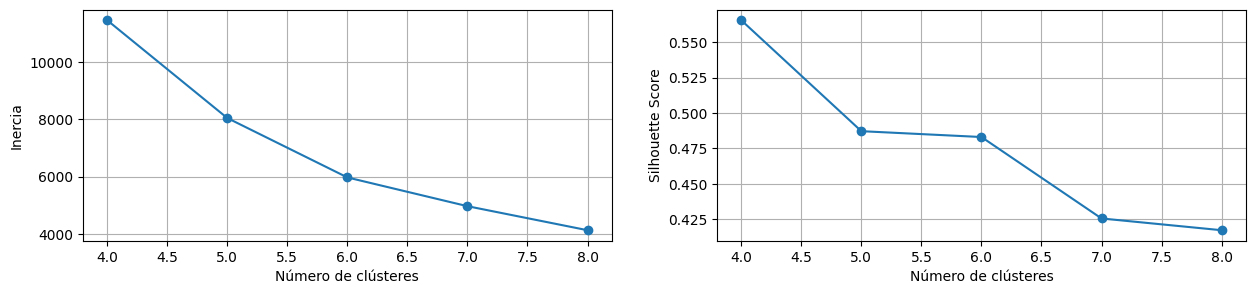

[INFO] 16:11:31 — PASO 3: Ejecución del algoritmo | Fin de la ejecución
[INFO] 16:11:31 — PASO 4: Visualización de resultados | Inicio de la ejecución


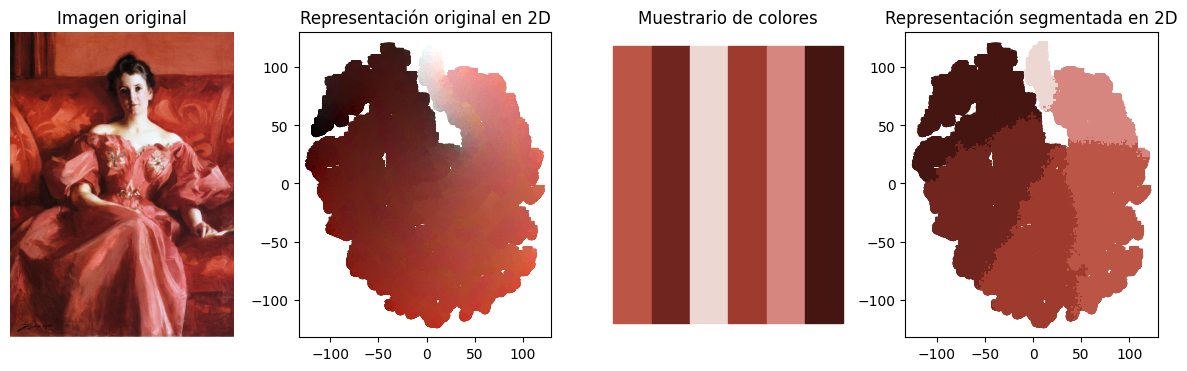

[INFO] 16:11:33 — PASO 4: Visualización de resultados | Fin de la ejecución
----



In [8]:
for i in range(len(img_files)):  
    context = Context(model=kmeans)
    steps = [
        ("loader", ImageLoader(context)),
        ("processor", ImageProcessor(context, num_components=10)),
        ("algorithm", Algorithm(context)),
        ("kmeans", kmeans),
        ("prettyPrinter", PrettyPrinter(context))
    ]
    pipeline = Pipeline(steps)
    pipeline.fit(img_files[i])